# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.style.use('ggplot')

TITLE_SIZE = 22
TITLE_PADDING = 10

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [12, 5],
   }
plt.rcParams.update(params)

import pandas as pd
pd.options.display.max_rows = 500

import numpy as np
from numpy import percentile
np.random.seed(42)

import copy
import os
import time
from tqdm.notebook import tqdm

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

from sklearn import set_config
set_config(display='diagram')

import lightgbm as lgb

from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from hyperopt.pyll.stochastic import sample

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Using techniques found on Kaggle
---

Until this point **I have not looked at any of the Kaggle kernels or discussions.** I just took the data, the codebook.csv and the [quite sparse competition overview](https://www.kaggle.com/c/costa-rican-household-poverty-prediction) and tried to understand the data and solve the problem on my own. 

For this third notebook I now take information from Kaggle and use that to learn and improve the results. I especially looked into the following notebooks and took code, suggestions and ideas:

- [A Complete Introduction and Walkthrough](https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough) 
- [LightGBM hyperoptimization with f1 macro](https://www.kaggle.com/chmaxx/lighgbm-hyperoptimisation-with-f1-macro)
- [Exploratory data analysis lightgbm](https://www.kaggle.com/gaxxxx/exploratory-data-analysis-lightgbm)
- [XGBoost](https://www.kaggle.com/skooch/xgboost) (though I did use LightGBM for any of my experiments and submissions)

### What can I learn in addition?

Some of the Kaggle ideas and techniques that I find valuable: 

**Data preparation**
- Retransform ordinals back from bools to give model more information about order of values 
- Remove perfectly or very highly correlated variables
- Add columns to indicate missing values

**Feature engineering**
- Create compositions of variables to get «overall» features, e.g. «overall quality of housing»
- Create «warning» features composed of crucial items that strongly indicate imminent poverty
- Count actual people living in household rather than being household members
- In general try much more feature combinations

**Coding**
- Use pandas' `agg` function to aggregate data to household level rather than using separate functions for mean/avg/std etc.

**Training**
- Use early stopping for LightGBM
- Use HyperOpt for hyperparameter search
- Visualize confidence of model in regard to target classes 

**Visualization**
- More thoroughly investigate and plot features in regard to target, e.g. schooling, gender, overcrowding
- Plot model performance with error bars

---
#### To Do
In this notebook I'd like to 
1. add some **feature engineering**
2. try to set up **early stopping**
3. use **HyperOpt** to improve hyperparameter search

# 0) Preparing the data again

In [3]:
train = pd.read_csv("_data/train.csv")
test_kaggle = pd.read_csv("_data/test.csv")
df = pd.concat([train, test_kaggle]).reset_index(drop=True)
print("Check data frame shapes before and after:")
print(train.shape, test_kaggle.shape, df.shape)

# Drop redundant features
derivative_features = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
                       'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 
                       'SQBmeaned', 'agesq', "female", "area2"]
df.drop(derivative_features, axis=1, inplace=True)

# Replace 0/1 for value «no»/«yes» according to Kaggle discussion
cols = ["dependency", "edjefe", "edjefa"]
for col in cols:
    df[col].replace({"no":0}, inplace=True)
    df[col].replace({"yes":1}, inplace=True)
    df[col] = df[col].astype(float)
    
# Clean the one erroneous value for rez_esc. Set to 5 according to Kaggle 
years_behind_mean = np.mean(train.rez_esc)
df.loc[df[df.rez_esc==99.0].index, "rez_esc"] = 5

# Clean target variable for households that have been qualified with more than one unique class of welfare neediness.
# We set the target class for all members to the one the head of household has.
tmp = df.groupby("idhogar").Target.nunique()
erroneous_households = tmp[tmp>1].index.to_list()
for household in erroneous_households:
    to_fix = df[df.idhogar==household].index
    true_class_label = df[(df.idhogar==household) & (df.parentesco1==1)].Target.values[0]
    df.loc[to_fix, "Target"] = true_class_label

# Remove households without a head of household.
# We only drop samples in the training set because we need all test samples for a Kaggle submission.
tmp = df[df.Target.notnull()].groupby("idhogar").parentesco1.sum()
without_head = tmp[tmp==0].index
to_drop = df[df.idhogar.isin(without_head)].index
df.drop(to_drop, inplace=True)    

# Split again into train and test set.
train = df[df.Target.notnull()].copy()
test_kaggle = df[df.Target.isnull()].copy()

train.reset_index(drop=True, inplace=True)
test_kaggle.reset_index(drop=True, inplace=True)

print(train.shape, test_kaggle.shape, df.shape)

Check data frame shapes before and after:
(9557, 143) (23856, 142) (33413, 143)
(9534, 132) (23856, 132) (33390, 132)


In [4]:
# Read manually annotated codebook
cb = pd.read_excel("_data/codebook_cleaned.xlsx")
to_drop = cb[cb.name.isin(["female", "area2", "idhogar", "Target"])].index
cb.drop(to_drop, inplace=True)
categoricals = cb[cb.cat==1].name.copy()
numericals = cb[cb.cat!=1].name.copy()

indiv_feats = cb[cb.indiv==1].name
house_feats = cb[cb.indiv!=1].name

In [5]:
def aggregate_to_household(data_set, aggregate_train=True):
    g = data_set.groupby("idhogar")
    results = []
    for name, data in tqdm(g):
        tmp = data[data.parentesco1==1].copy()
        tmp = tmp[house_feats].reset_index(drop=True)
        
        tmp_indiv = data[indiv_feats]
        feats_mean = np.mean(tmp_indiv)
        feats_mean = pd.DataFrame(feats_mean).T
        feats_mean.columns = feats_mean.columns + "_mean"
        
        feats_std = pd.DataFrame(np.std(tmp_indiv)).T
        feats_std.columns = feats_std.columns + "_std"
        
        feats_sum = pd.DataFrame(np.sum(tmp_indiv)).T
        feats_sum.columns = feats_sum.columns + "_sum"

        row = pd.concat([tmp, feats_mean, feats_std, feats_sum], axis=1)

        row["Id"] = data[data.parentesco1==1].Id.values
        row["idhogar"] = data[data.parentesco1==1].idhogar.values
        
        if aggregate_train==True:
            row["Target"] = data[data.parentesco1==1].Target.values
        else:
            row["Target"] = None
            
        results.append(row)
        
    return pd.concat(results).reset_index(drop=True)

In [6]:
train_agg = aggregate_to_household(train)

X_agg = train_agg.drop(["Id", "idhogar", "Target"], axis=1).copy()
y_agg = train_agg.Target

  0%|          | 0/2973 [00:00<?, ?it/s]

# 1) Additional feature engineering
---
In this step I add various additional features mainly using ideas from [this notebook](https://www.kaggle.com/gaxxxx/exploratory-data-analysis-lightgbm).
- Unfortunately these additional features do not improve the score.

In [7]:
def create_additional_features():
    X_agg['dependency_count'] = X_agg['hogar_nin'] + X_agg['hogar_mayor']
    X_agg['child_percent'] = X_agg['hogar_nin'] / X_agg['hogar_total']
    X_agg['elder_percent'] = X_agg['hogar_mayor'] / X_agg['hogar_total']
    X_agg['adult_percent'] = X_agg['hogar_adul'] / X_agg['hogar_total']

    X_agg['rent_per_adult'] = X_agg['v2a1'] / X_agg['hogar_adul']
    X_agg['rent_per_person'] = X_agg['v2a1'] / X_agg['hhsize']

    X_agg['r4h1_percent_in_male'] = X_agg['r4h1'] / X_agg['r4h3']
    X_agg['r4m1_percent_in_female'] = X_agg['r4m1'] / X_agg['r4m3']
    X_agg['r4h1_percent_in_total'] = X_agg['r4h1'] / X_agg['hhsize']
    X_agg['r4m1_percent_in_total'] = X_agg['r4m1'] / X_agg['hhsize']
    X_agg['r4t1_percent_in_total'] = X_agg['r4t1'] / X_agg['hhsize']

    X_agg['rent_per_room'] = X_agg['v2a1'] / X_agg['rooms']
    X_agg['bedroom_per_room'] = X_agg['bedrooms'] / X_agg['rooms']
    X_agg['elder_per_room'] = X_agg['hogar_mayor'] / X_agg['rooms']
    X_agg['child_per_room'] = X_agg['hogar_nin'] / X_agg['rooms']
    X_agg['male_per_room'] = X_agg['r4h3'] / X_agg['rooms']
    X_agg['female_per_room'] = X_agg['r4m3'] / X_agg['rooms']
    X_agg['room_per_person_household'] = X_agg['hhsize'] / X_agg['rooms']

    X_agg['rent_per_bedroom'] = X_agg['v2a1'] / X_agg['bedrooms']
    X_agg['edler_per_bedroom'] = X_agg['hogar_mayor'] / X_agg['bedrooms']
    X_agg['child_per_bedroom'] = X_agg['hogar_nin'] / X_agg['bedrooms']
    X_agg['male_per_bedroom'] = X_agg['r4h3'] / X_agg['bedrooms']
    X_agg['female_per_bedroom'] = X_agg['r4m3'] / X_agg['bedrooms']
    X_agg['bedrooms_per_person_household'] = X_agg['hhsize'] / X_agg['bedrooms']

    X_agg['overcrowding_room_and_bedroom'] = (X_agg['hacdor'] + X_agg['hacapo'])/2

    X_agg['no_appliances'] = X_agg['refrig'] + X_agg['computer'] + X_agg['television']
    X_agg['tablet_per_person_household'] = X_agg['v18q1'] / X_agg['hhsize']
    X_agg['phone_per_person_household'] = X_agg['qmobilephone'] / X_agg['hhsize']

    X_agg['age_12_19'] = X_agg['hogar_nin'] - X_agg['r4t1']

In [8]:
def train_model():
    params = {"n_estimators": 1000, 
              'learning_rate': 0.022, 
              'num_leaves': 6,
              'max_depth': 28, 
              'class_weight': 'balanced', 
              "n_jobs": -1, 
              "random_state": 42, 
              }

    clf = lgb.LGBMClassifier(**params)
    scores = cross_val_score(clf, X_agg, y_agg, scoring="f1_macro", n_jobs=-1, cv=10)
    mean_score = np.mean(scores)
    print(f"{mean_score:.4f}")

In [9]:
print("Before additional feature engineering:")
train_model()
print()

create_additional_features()

print("After additional feature engineering:")
train_model()

Before additional feature engineering:
0.4258

After additional feature engineering:
0.4183


# 2) Using LightGBM's early stopping
---
- **Early stopping is supposed to prevent overfitting** since the training stops once there is no more improvement after a given limit of rounds. 
- Early stopping also can **speed up training** since the fitting stops at the optimal point plus n stopping rounds.
- In my case, training with early stopping yields a better local score of **0.45**

I take much of the following code from [Will's notebook](https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough?scriptVersionId=5196152&cellId=139).

In [10]:
# Define custom metric to be used for HyperOpt later on, but we can already implement it here
def macro_f1_score(labels, predictions):
    # https://github.com/Microsoft/LightGBM/issues/1483
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis=0)
    metric_value = f1_score(labels, predictions, average='macro')
    return 'macro_f1', metric_value, True

In [11]:
%%time
params = {'learning_rate': 0.002, 
          'class_weight': 'balanced', 
          "n_jobs": -1, 
          "random_state": 42, 
          "n_estimators": 5_000, 
          }

model = lgb.LGBMClassifier(**params)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = []
best_estimators = []

for train_index, val_index in skf.split(X_agg, y_agg):
    model.fit(X_agg.loc[train_index], y_agg[train_index], 
              # The training stops once there is no more improvement on the validation set for 1000 rounds.
              # Every training «round» is equivalent to building one more estimator in the gradient boosting chain.
              early_stopping_rounds=1000, 
              eval_metric=macro_f1_score,
              eval_set=[(X_agg.loc[train_index], y_agg[train_index]), (X_agg.loc[val_index], y_agg[val_index])],
              eval_names=["train", 'test'],
              verbose=200)
        
    scores.append([model.best_score_["test"]["macro_f1"]])
    best_estimators.append(model.best_iteration_)

estimators = int(np.mean(best_estimators))
print(f"F1 macro validated: {np.mean(scores):.4f} with an average of {estimators} estimators\n")

[200]	train's multi_logloss: 1.092	train's macro_f1: 0.683467	test's multi_logloss: 1.17497	test's macro_f1: 0.406193
[400]	train's multi_logloss: 0.923941	train's macro_f1: 0.721496	test's multi_logloss: 1.07555	test's macro_f1: 0.424588
[600]	train's multi_logloss: 0.809449	train's macro_f1: 0.754082	test's multi_logloss: 1.02239	test's macro_f1: 0.448959
[800]	train's multi_logloss: 0.723626	train's macro_f1: 0.781662	test's multi_logloss: 0.988271	test's macro_f1: 0.449004
[1000]	train's multi_logloss: 0.654895	train's macro_f1: 0.805941	test's multi_logloss: 0.965509	test's macro_f1: 0.440777
[1200]	train's multi_logloss: 0.595439	train's macro_f1: 0.825597	test's multi_logloss: 0.95017	test's macro_f1: 0.443549
[1400]	train's multi_logloss: 0.543912	train's macro_f1: 0.844177	test's multi_logloss: 0.94255	test's macro_f1: 0.444583
[1600]	train's multi_logloss: 0.499007	train's macro_f1: 0.862355	test's multi_logloss: 0.934441	test's macro_f1: 0.445669
[200]	train's multi_logloss:

# 3) Using HyperOpt for hyperparameter search
---
**[HyperOpt](https://github.com/hyperopt/hyperopt) is yet another library that aims to help with hyperparameter search.** 

Like several of the available AutoML solutions, HyperOpt constructs a proxy model of the objective function. Instead of directly maximizing the model's objective, HyperOpt optimizes the proxy model and by that tries to find the best next parameter combination to try out. This might substantially reduce search time and possibly find better hyperparameters.

HyperOpt lets us use one out of three available algorithms for choosing the next values in the parameter search. 
- `tpe.suggest` (which is the one I use here) is the «Tree Parzen Estimator» which uses the Bayes rule.
- tpe maximizes the «Expected Improvement» of the proxy model.

Note: There is an extension available called [hyperopt-sklearn](https://hyperopt.github.io/hyperopt-sklearn/) that allows to more tightly integrate HyperOpt into scikit-learn pipelines.

In [12]:
# HyperOpt needs an objective function to minimize that has to follow certain conventions.
# https://github.com/hyperopt/hyperopt/wiki/FMin
# Again, code here is an adapted version of Will Koehrsen Kaggle code 
def objective_func(hyperparameters):
    
    # Assert that parameters that need to be integers are integers
    parameters = ['num_leaves', 'subsample_for_bin', 'min_child_samples', 'subsample_freq']
    for parameter in parameters:
        hyperparameters[parameter] = int(hyperparameters[parameter])
        
    model = lgb.LGBMClassifier(**hyperparameters,
                               class_weight='balanced',
                               n_jobs=-1, 
                               random_state= 42, 
                               n_estimators= 5_000, 
                               )
    
    valid_scores = []
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for train_index, val_index in skf.split(X_agg, y_agg):
        
        model.fit(X_agg.loc[train_index], y_agg[train_index], 
                  early_stopping_rounds=500, 
                  eval_metric=macro_f1_score,
                  eval_set=[(X_agg.loc[val_index], y_agg[val_index])],
                  eval_names=["valid"],
                  verbose=0)
        
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        best_estimators.append(model.best_iteration_)
    
    score = np.mean(valid_scores)
    score_std = np.std(valid_scores)
    
    # Hyperopt needs a score to *minimize*, so we need to return 1 - Macro F1 score as loss.
    loss = 1 - score
    
    return {'loss': loss, 'status': STATUS_OK, 
            'hyperparameters': hyperparameters,
            'score': score, 'score_std': score_std}

In [13]:
# Define the search space for HyperOpt
space = {
        'subsample': hp.uniform('subsample', 0.1, 1),
        'subsample_freq': hp.quniform('subsample_freq', 1, 10, 1), 
        'subsample_for_bin': hp.quniform('subsample_for_bin', 2000, 200000, 2000),
        'num_leaves': hp.quniform('num_leaves', 3, 60, 1),
        'learning_rate': hp.loguniform('learning_rate', 
                                       np.log(0.01), 
                                       np.log(0.2)),
        'min_child_samples': hp.quniform('min_child_samples', 5, 80, 5),
        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
        }

In [14]:
%%time
trials = Trials()
best = fmin(fn=objective_func, 
            space=space, 
            algo=tpe.suggest, 
            trials=trials,
            # By default tpe selects the first hyperparameters for the first 20 evalution rounds randomly.
            # It does so as a warm up to get an idea of where to start.
            # Only then the algorithm begins to optimize next steps in search space.
            # https://github.com/hyperopt/hyperopt/issues/642
            max_evals=50)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [36:55<00:00, 44.32s/trial, best loss: 0.5328411887687478]
CPU times: user 2h 33min 57s, sys: 59min 52s, total: 3h 33min 49s
Wall time: 36min 55s


## Visualize results
By plotting the score of each iteration we can observe the improvement HyperOpt makes throughout the search. 
- We need to discard the first 20 iterations because HyperOpt samples these first iterations randomly as a warmup. 
- Iteration #32 yields the best score - **0.4648**

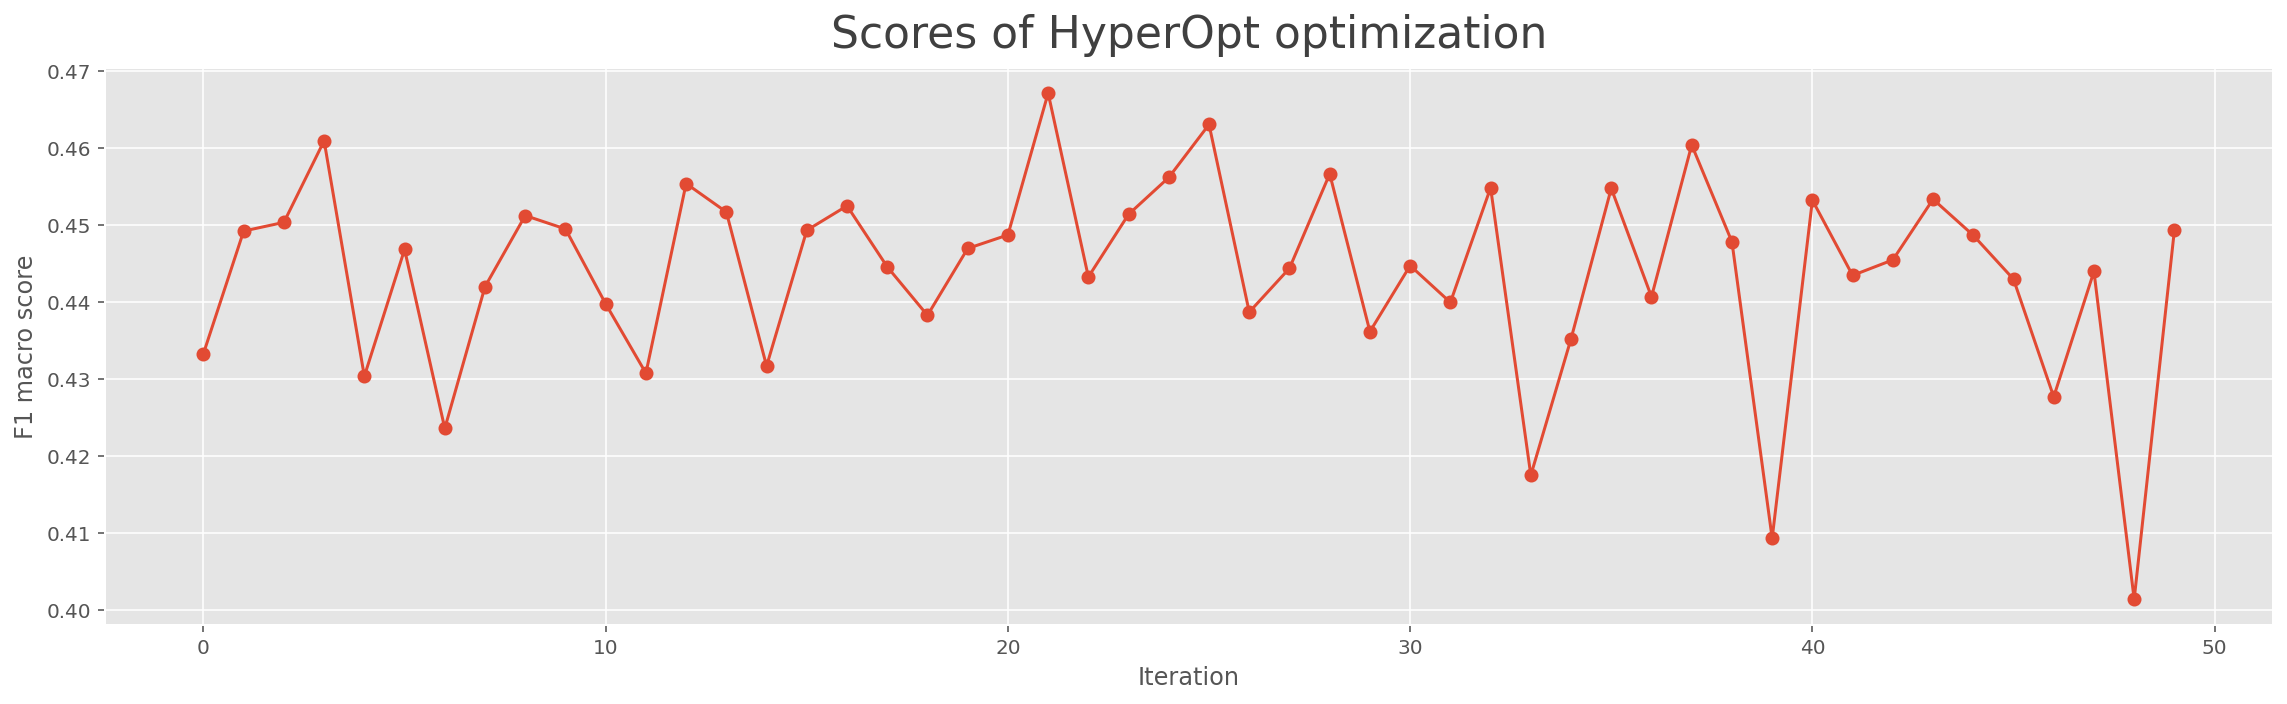

In [15]:
results = pd.DataFrame.from_dict(trials.results)
results.drop("status", axis=1, inplace=True)
results.reset_index(inplace=True)
results.score.plot(figsize=(16,5), marker="o")
plt.title("Scores of HyperOpt optimization", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.xlabel("Iteration")
plt.ylabel("F1 macro score")
plt.tight_layout()
plt.show()

In [16]:
results.sort_values("score", ascending=False, inplace=True)
results.reset_index(inplace=True)
results.rename({"index":"iteration"}, axis=1, inplace=True)
display(results.iloc[:10])

,level_0,iteration,loss,hyperparameters,score,score_std
0,21,21,0.532841,"{'learning_rate': 0.010091506146341857, 'min_c...",0.467159,0.028698
1,25,25,0.536920,"{'learning_rate': 0.02728632665625051, 'min_ch...",0.463080,0.020347
2,3,3,0.539043,"{'learning_rate': 0.01093187949330154, 'min_ch...",0.460957,0.026682
3,37,37,0.539580,"{'learning_rate': 0.010105771702845483, 'min_c...",0.460420,0.025477
4,28,28,0.543342,"{'learning_rate': 0.025315714672400545, 'min_c...",0.456658,0.023230
5,24,24,0.543801,"{'learning_rate': 0.01076106436790391, 'min_ch...",0.456199,0.023058
6,12,12,0.544596,"{'learning_rate': 0.09186236464674087, 'min_ch...",0.455404,0.015036
7,32,32,0.545146,"{'learning_rate': 0.016713762981425975, 'min_c...",0.454854,0.023859
8,35,35,0.545226,"{'learning_rate': 0.01244156648379928, 'min_ch...",0.454774,0.036254
9,43,43,0.546634,"{'learning_rate': 0.01388339925958831, 'min_ch...",0.453366,0.035780


In [17]:
params = results.loc[0].hyperparameters
print("Best found hyperparameters are:\n")
display(params)

# # make sure found params are really the optimal ones
# from hyperopt import space_eval
# display(space_eval(space, best))

Best found hyperparameters are:



{'learning_rate': 0.010091506146341857,
 'min_child_samples': 45,
 'num_leaves': 28,
 'reg_alpha': 0.20657994563833657,
 'reg_lambda': 0.42853957052345515,
 'subsample': 0.2574762456012337,
 'subsample_for_bin': 64000,
 'subsample_freq': 6}

## Validate best found hyperparameters

In [18]:
%%time
# Set n_estimators to very high value again to allow for a wider range when using early stopping
# otherwise default of 100 from LGBM would be used
params["n_estimators"] = 5_000
model = lgb.LGBMClassifier(**params,
                           class_weight='balanced',
                           n_jobs=-1, 
                           random_state= 42,
                          )

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = []

for train_index, val_index in skf.split(X_agg, y_agg):
    model.fit(X_agg.loc[train_index], y_agg[train_index], 
              early_stopping_rounds=250, 
              eval_metric=macro_f1_score,
              eval_set=[(X_agg.loc[val_index], y_agg[val_index])],
              eval_names=["valid"],
              verbose=0)
    preds = model.predict(X_agg.loc[val_index])
    scores.append(model.best_score_["valid"]["macro_f1"])
    
print(f"F1 macro validated: {np.mean(scores):.4f}\n")

F1 macro validated: 0.4673

CPU times: user 1min 58s, sys: 45.5 s, total: 2min 44s
Wall time: 23.4 s


**The best hyperparameters I could find with HyperOpt yield 0.4367 on Kaggle (rank #89 from previous #111)**, which is a substantial gain and the **best result so far.**

I had to increase the early stopping rounds, create a model out of each fold of crossvalidation (10 in total), made predictions with each of these and averaged the results.

# 4) Conclusions
---

- **An interesting and challenging data set to work with.**
- As usual there was a wealth of things to learn from others on Kaggle. Unfortunately the winning solutions weren't published. I'd would have been great to see how this competition was won and how the organizers used all the ideas and code to improve the assessment of poverty. 
- I had some difficulties in setting up early stopping correctly. It took me a lot of experimenting and refactoring code until I had all the parameters and workflow in place so that results actually were valid. However, early stopping brought substantial gains, especially in combination with hyperparameter search with HyperOpt. 
- I hadn't used HyperOpt before and found it to be an interesting and helpful tool.